In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Importing the Libraries 

In [24]:
import tensorflow as tf 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow import keras 

from tensorflow.keras import models
from tensorflow.keras.models import Model
from google.colab.patches import cv2_imshow
from tensorflow.keras.applications import MobileNetV2, InceptionV3, InceptionResNetV2
from tensorflow.keras.layers import Dense, Dropout, Flatten, Input
from tensorflow.keras.callbacks import TensorBoard

In [3]:
import xml.etree.ElementTree as xet
from glob import glob
import os 
import cv2

## Getting Data 

In [4]:
path = glob('/content/drive/MyDrive/tensorflow/Car number plate detection /images/*.xml')

In [5]:
path[:6]

['/content/drive/MyDrive/tensorflow/Car number plate detection /images/N1.xml',
 '/content/drive/MyDrive/tensorflow/Car number plate detection /images/N2.xml',
 '/content/drive/MyDrive/tensorflow/Car number plate detection /images/N3.xml',
 '/content/drive/MyDrive/tensorflow/Car number plate detection /images/N4.xml',
 '/content/drive/MyDrive/tensorflow/Car number plate detection /images/N5.xml',
 '/content/drive/MyDrive/tensorflow/Car number plate detection /images/N6.xml']

### Converting xml to csv 

In [6]:
labels_dict = dict(filepath=[],xmin=[],xmax=[],ymin=[],ymax=[])
for filename in path :
  #filename = path[0]
  info = xet.parse(filename)
  root = info.getroot()
  member_object = root.find('object')
  labels_info = member_object.find('bndbox')
  xmin = int(labels_info.find('xmin').text)
  xmax = int(labels_info.find('xmax').text)
  ymin = int(labels_info.find('ymin').text)
  ymax = int(labels_info.find('ymax').text)
  labels_dict['filepath'].append(filename)
  labels_dict['xmin'].append(xmin)
  labels_dict['xmax'].append(xmax)
  labels_dict['ymin'].append(ymin)
  labels_dict['ymax'].append(ymax)



In [7]:
df = pd.DataFrame(labels_dict)
df.head()

,filepath,xmin,xmax,ymin,ymax
0,/content/drive/MyDrive/tensorflow/Car number p...,1093,1396,645,727
1,/content/drive/MyDrive/tensorflow/Car number p...,1804,2493,1734,1882
2,/content/drive/MyDrive/tensorflow/Car number p...,73,260,381,462
3,/content/drive/MyDrive/tensorflow/Car number p...,1326,1830,1464,1607
4,/content/drive/MyDrive/tensorflow/Car number p...,938,1173,709,762


In [8]:
df.to_csv('/content/drive/MyDrive/tensorflow/Car number plate detection /labels.csv',index=False)

### Labels and Images 

In [9]:
filename = df['filepath'][0]
filename

'/content/drive/MyDrive/tensorflow/Car number plate detection /images/N1.xml'

In [10]:
def getFilename(filename):
  filename_image = xet.parse(filename).getroot().find('filename').text
  filepath_image = os.path.join('/content/drive/MyDrive/tensorflow/Car number plate detection /images',filename_image)
  return filepath_image

In [11]:
getFilename(filename)

'/content/drive/MyDrive/tensorflow/Car number plate detection /images/N1.jpeg'

In [12]:
image_path = list(df['filepath'].apply(getFilename))

In [13]:
image_path[:5]

['/content/drive/MyDrive/tensorflow/Car number plate detection /images/N1.jpeg',
 '/content/drive/MyDrive/tensorflow/Car number plate detection /images/N2.jpeg',
 '/content/drive/MyDrive/tensorflow/Car number plate detection /images/N3.jpeg',
 '/content/drive/MyDrive/tensorflow/Car number plate detection /images/N4.jpeg',
 '/content/drive/MyDrive/tensorflow/Car number plate detection /images/N5.jpeg']

## visualisation of data 

In [14]:
file_path = image_path[0]

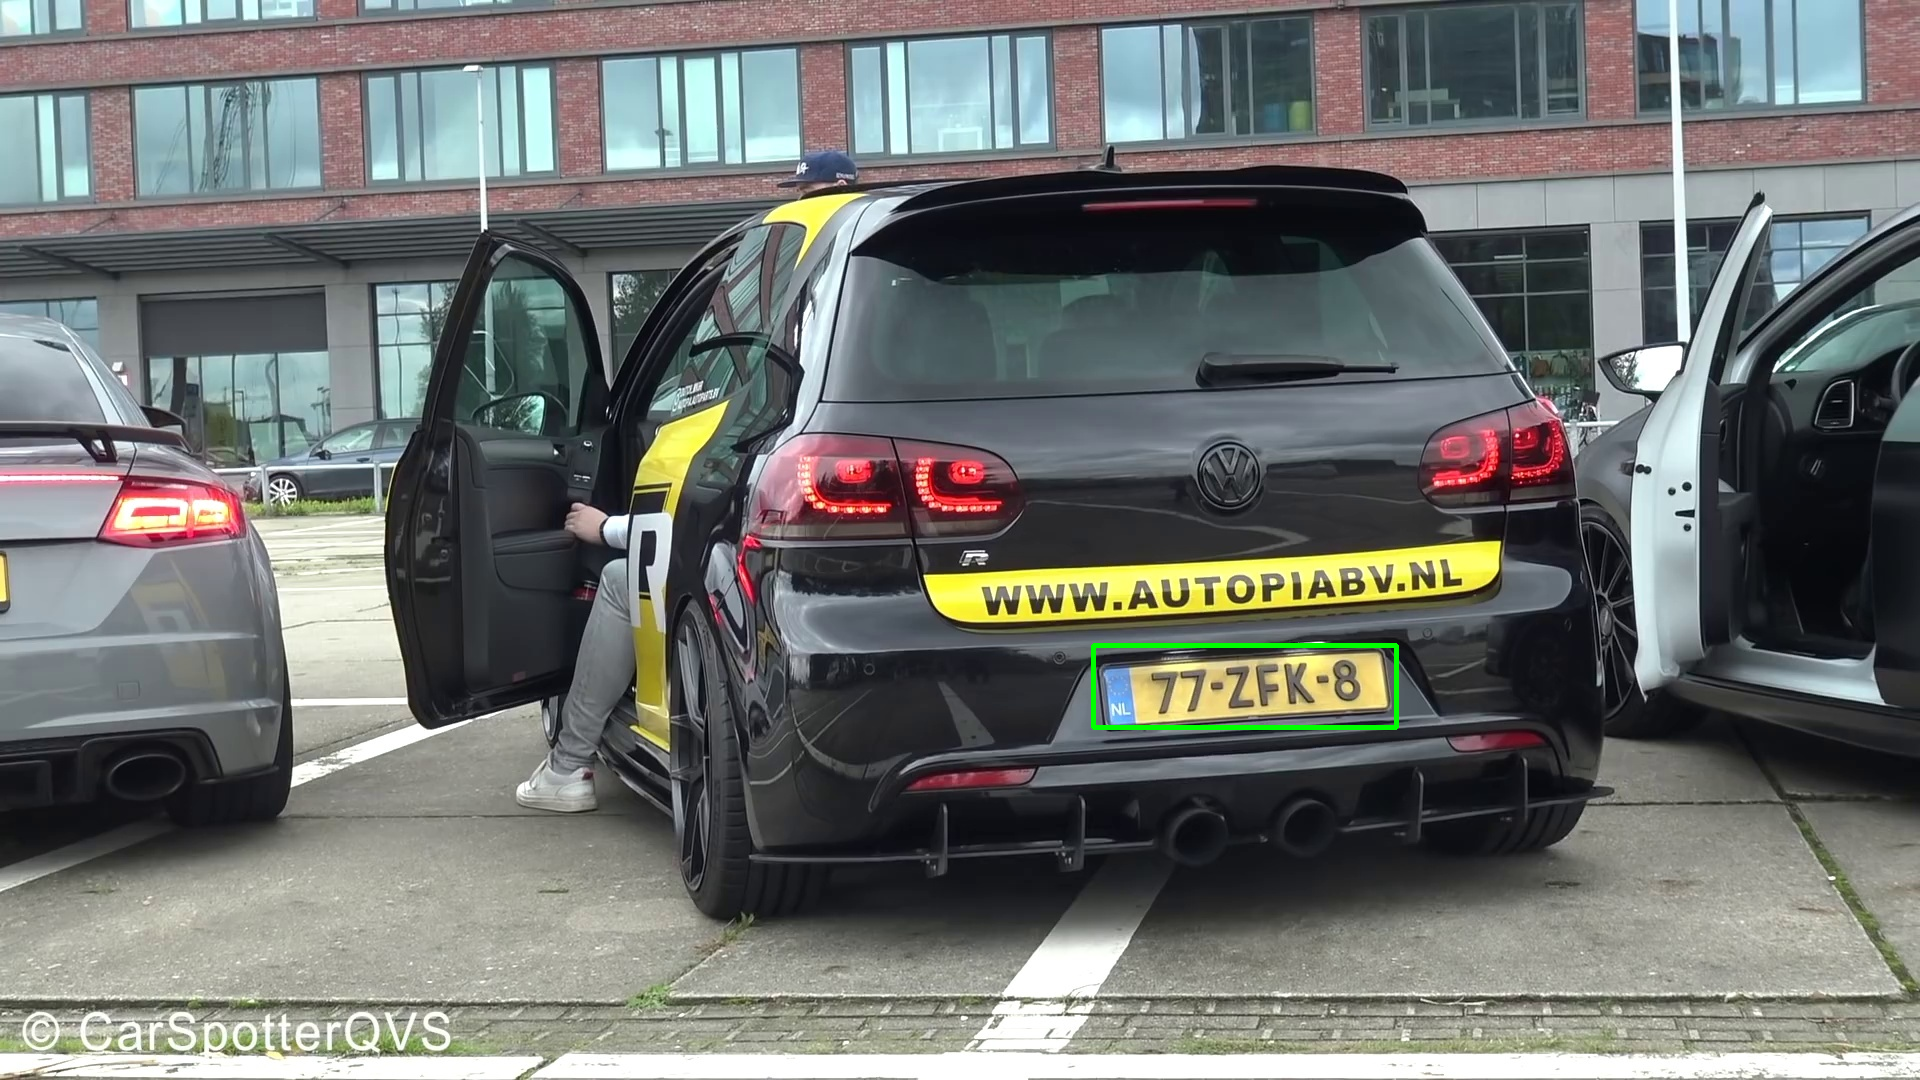

In [15]:
img = cv2.imread(file_path)
cv2.rectangle(img,(1093,645),(1396,727),(0,255,0),3)
cv2_imshow(img)

## Data Preprocessing 

In [16]:
from sklearn. model_selection import train_test_split
from tensorflow. keras. preprocessing. image import load_img, img_to_array

In [17]:
labels = df.iloc[:,1:].values

In [18]:
data = []
output = []
for ind in range(len(image_path)):
    image = image_path[ind]
    img_arr = cv2.imread(image)
    h,w,d = img_arr.shape
    # prepprocesing
    load_image = load_img(image,target_size=(224,224))
    load_image_arr = img_to_array(load_image)
    norm_load_image_arr = load_image_arr/255.0 # normalization
    # normalization to labels
    xmin,xmax,ymin,ymax = labels[ind]
    nxmin,nxmax = xmin/w,xmax/w
    nymin,nymax = ymin/h,ymax/h
    label_norm = (nxmin,nxmax,nymin,nymax) # normalized output
    # -------------- append
    data.append(norm_load_image_arr)
    output.append(label_norm)

In [19]:
X = np.array(data,dtype=np.float32)
y = np.array(output,dtype=np.float32)

In [20]:
x_train,x_test,y_train,y_test = train_test_split(X,y,train_size=0.8,random_state=0)
x_train.shape,x_test.shape,y_train.shape,y_test.shape

((180, 224, 224, 3), (45, 224, 224, 3), (180, 4), (45, 4))

In [25]:
inception_resnet = InceptionResNetV2(weights="imagenet",include_top=False,
                                     input_tensor=Input(shape=(224,224,3)))
inception_resnet.trainable=False
# ---------------------
headmodel = inception_resnet.output
headmodel = Flatten()(headmodel)
headmodel = Dense(500,activation="relu")(headmodel)
headmodel = Dense(250,activation="relu")(headmodel)
headmodel = Dense(4,activation='sigmoid')(headmodel)
# ---------- model
model = Model(inputs=inception_resnet.input,outputs=headmodel)

In [26]:
model.compile(loss='mse',optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4))
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d_203 (Conv2D)             (None, 111, 111, 32) 864         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_203 (BatchN (None, 111, 111, 32) 96          conv2d_203[0][0]                 
__________________________________________________________________________________________________
activation_203 (Activation)     (None, 111, 111, 32) 0           batch_normalization_203[0][0]    
______________________________________________________________________________________________

In [27]:
tfb = TensorBoard('object_detection')

In [28]:
history = model.fit(x=x_train,y=y_train,batch_size=10,epochs=100,
                    validation_data=(x_test,y_test),callbacks=[tfb])

Epoch 1/100
18/18 [==============================] - 32s 388ms/step - loss: 0.1158 - val_loss: 0.1069
Epoch 2/100
18/18 [==============================] - 2s 96ms/step - loss: 0.1059 - val_loss: 0.0889
Epoch 3/100
18/18 [==============================] - 2s 96ms/step - loss: 0.0958 - val_loss: 0.0827
Epoch 4/100
18/18 [==============================] - 2s 97ms/step - loss: 0.0862 - val_loss: 0.0872
Epoch 5/100
18/18 [==============================] - 2s 97ms/step - loss: 0.0924 - val_loss: 0.0833
Epoch 6/100
18/18 [==============================] - 2s 97ms/step - loss: 0.0832 - val_loss: 0.0869
Epoch 7/100
18/18 [==============================] - 2s 97ms/step - loss: 0.0834 - val_loss: 0.0931
Epoch 8/100
18/18 [==============================] - 2s 98ms/step - loss: 0.0821 - val_loss: 0.0825
Epoch 9/100
18/18 [==============================] - 2s 97ms/step - loss: 0.0793 - val_loss: 0.0741
Epoch 10/100
18/18 [==============================] - 2s 97ms/step - loss: 0.0756 - val_loss: 0.08

In [31]:
history = model.fit(x=x_train,y=y_train,batch_size=10,epochs=120,
                    validation_data=(x_test,y_test),callbacks=[tfb],initial_epoch = 101)

Epoch 102/120
18/18 [==============================] - 3s 158ms/step - loss: 3.0292e-04 - val_loss: 0.0069
Epoch 103/120
18/18 [==============================] - 2s 104ms/step - loss: 2.5288e-04 - val_loss: 0.0069
Epoch 104/120
18/18 [==============================] - 2s 103ms/step - loss: 2.4027e-04 - val_loss: 0.0074
Epoch 105/120
18/18 [==============================] - 2s 120ms/step - loss: 2.5539e-04 - val_loss: 0.0067
Epoch 106/120
18/18 [==============================] - 2s 104ms/step - loss: 2.8958e-04 - val_loss: 0.0076
Epoch 107/120
18/18 [==============================] - 2s 120ms/step - loss: 3.4356e-04 - val_loss: 0.0067
Epoch 108/120
18/18 [==============================] - 2s 103ms/step - loss: 4.5894e-04 - val_loss: 0.0072
Epoch 109/120
18/18 [==============================] - 2s 119ms/step - loss: 3.7597e-04 - val_loss: 0.0067
Epoch 110/120
18/18 [==============================] - 2s 105ms/step - loss: 3.6162e-04 - val_loss: 0.0068
Epoch 111/120
18/18 [================

In [32]:
model.save('/content/drive/MyDrive/tensorflow/Car number plate detection /object_detection.h5')